# Inception Time

Here we will attempt to apply Conv1D layers for prediction time series. We are going to use the same datasets, as we gained in the roti.ipynb file.

the main purpose of this implementation - obtain the predictions results from inception network and compare them with the previous network, which consisted of LSTM and Dense layers.

In [1]:
import imports as im
import functions as fn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'jpg'

2023-05-26 15:50:53.147329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path_file = '../data/roti/2010-2020/roti'
# roti data and date
roti_map_date = []
roti_maps = []
# get date and roti maps
roti_map_date, roti_maps = fn.get_array_roti(path_file)

roti_maps_reshape = roti_maps.reshape(roti_maps.shape[0], 3600)

print("shape roti data ", roti_maps.shape)
print("shape roti data reshape", roti_maps_reshape.shape)
print("shape roti date line ", roti_map_date.shape)

shape roti data  (4469, 20, 180)
shape roti data reshape (4469, 3600)
shape roti date line  (4469, 3)


In [3]:
# get maps data
new_roti_maps = fn.roti_encode(roti_maps_reshape, 1)
# get average map for each day for training dataset
train_roti_maps = fn.roti_encode(roti_maps_reshape, 3600)

print(new_roti_maps.shape)
print(train_roti_maps.shape)

(4469, 3600)
(4469, 1)


In [4]:
filename = "../data/imf-bz-f107-au-al/omni2_Shvf6pN7UL.lst.txt"
# get training arrays of indeces' data
data_all_arr, date_arr = fn.get_all_data(filename, train_roti_maps, roti_map_date, day_end=19, month_end=6, year_end=2022)

print(data_all_arr.shape)

(4468, 9)


In [5]:
train_num = 3100
all_indexes = fn.mean_data(data_all_arr, train_num=train_num)

start_index = 0
end_index = 3100
end_index_val = 3935
# end_index = 9000
history_size = 2
target_size = 1
batch_size = 24
buffer_size = 256

x_train, y_train = fn.multivariate_data(all_indexes, new_roti_maps, start_index, end_index, history_size, target_size)
x_train_test, y_train_test = fn.multivariate_data_test(all_indexes, new_roti_maps, 0, None, history_size, target_size)

x_val, y_val = fn.multivariate_data(all_indexes, new_roti_maps, end_index, end_index_val, history_size, target_size)

train_data = im.tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data = im.tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).repeat()

2023-05-26 15:53:15.280324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
print(x_train.shape)
print(x_train_test.shape)
print(x_val.shape)

(3086, 2, 9)
(4465, 2, 9)
(833, 2, 9)


In [12]:
def make_model(input_shape):
    input_layer = im.keras.layers.Input(input_shape)

    conv1 = im.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(input_layer)
    conv1 = im.keras.layers.BatchNormalization()(conv1)
    conv1 = im.keras.layers.ReLU()(conv1)

    conv2 = im.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv1)
    conv2 = im.keras.layers.BatchNormalization()(conv2)
    conv2 = im.keras.layers.ReLU()(conv2)

    conv3 = im.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv2)
    conv3 = im.keras.layers.BatchNormalization()(conv3)
    conv3 = im.keras.layers.ReLU()(conv3)

    gap = im.keras.layers.GlobalAveragePooling1D()(conv3)

    layer1 = im.keras.layers.Dense(512, activation="selu")(gap)
    layer2 = im.keras.layers.Dense(2048, activation="selu")(layer1)
    output_layer = im.keras.layers.Dense(y_train.shape[-1], activation="sigmoid")(layer2)

    return im.keras.models.Model(inputs=input_layer, outputs=output_layer)

inception = make_model(input_shape=x_train.shape[1:])
inception.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 9)]            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 128)            3584      
                                                                 
 batch_normalization_3 (Batc  (None, 2, 128)           512       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 2, 128)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 128)            49280     
                                                                 
 batch_normalization_4 (Batc  (None, 2, 128)           512       
 hNormalization)                                           

In [42]:
epochs = 100
# weights_inception = "../weights/Inception.h5"

callbacks = [
    # im.keras.callbacks.ModelCheckpoint(
    #     weights_inception, save_best_only=True, monitor="val_loss"
    # ),
    im.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.7, patience=10, mode='min', min_lr=0
    ),
    im.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
inception.compile(
    optimizer="adam",
    loss=im.tf.keras.losses.Huber(delta=2.15),
    metrics=['accuracy'],
)

In [50]:
HistoryInception = inception.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[callbacks],
    validation_data=val_data,
    validation_steps=x_val.shape[0] // batch_size,
    verbose=1,
)

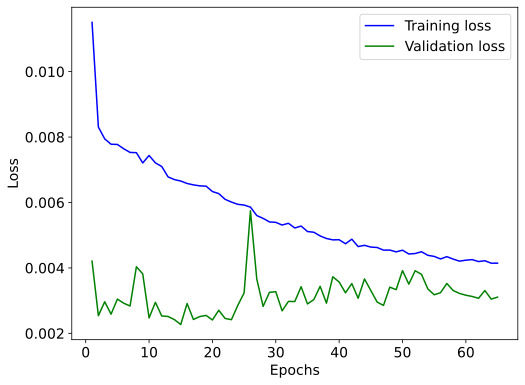

In [44]:
loss = HistoryInception.history['loss']
val_loss = HistoryInception.history['val_loss']
epochs = range(1, len(loss) + 1)

fn.PlotLossAcc(loss, val_loss, epochs, TrainLabel='Training loss', ValLabel='Validation loss',
               yLabel="Loss", filename="../images/inception_loss.pdf")

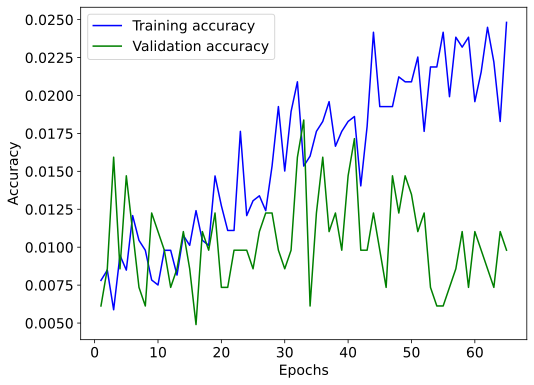

In [45]:
accuracy = HistoryInception.history['accuracy']
val_accuracy = HistoryInception.history['val_accuracy']
epochs = range(1, len(loss) + 1)

fn.PlotLossAcc(accuracy, val_accuracy, epochs, TrainLabel='Training accuracy', ValLabel='Validation accuracy',
               yLabel="Accuracy", filename="../images/inception_acc.pdf")

1/1 [==============================] - 0s 99ms/step


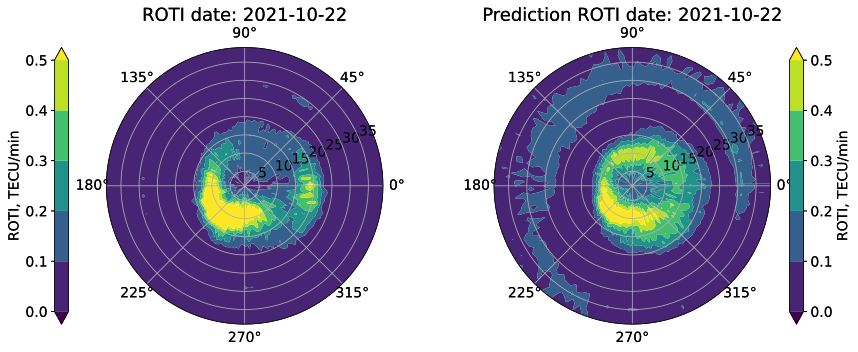

In [46]:
start = 4226
end = start + 1

y_pred=inception.predict(x_train_test[start:end])

fn.PlotRotiPredictions(start, end, y_pred, x_train_test, roti_map_date, pdf_file="", WriteFile=False)

1/1 [==============================] - 0s 16ms/step


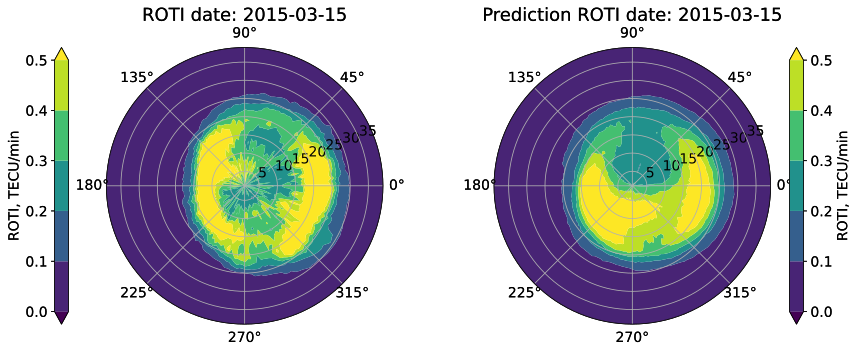

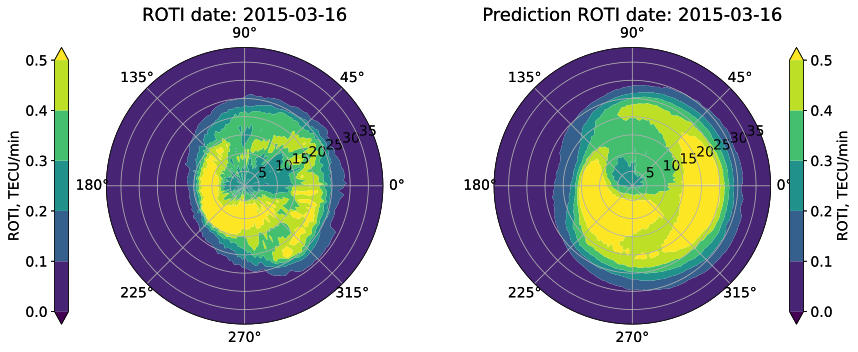

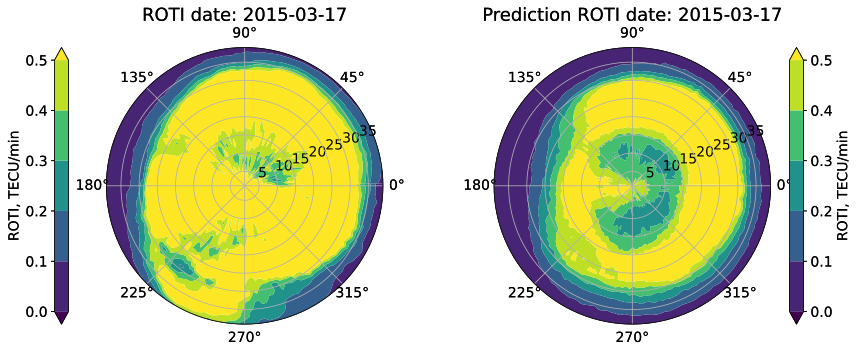

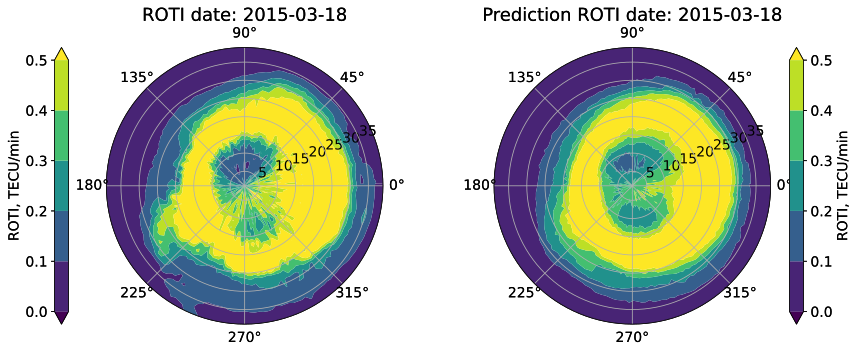

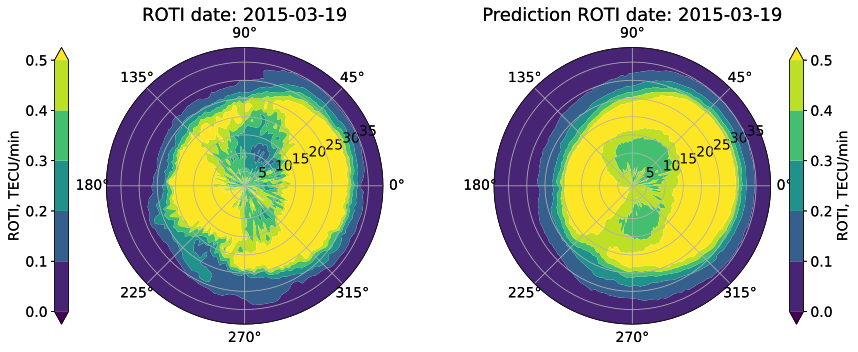

In [47]:
start = 1897
end = 1902

y_pred=inception.predict(x_train_test[start:end])

fn.PlotRotiPredictions(start, end, y_pred, x_train_test, roti_map_date, pdf_file="", WriteFile=False)

1/1 [==============================] - 0s 17ms/step


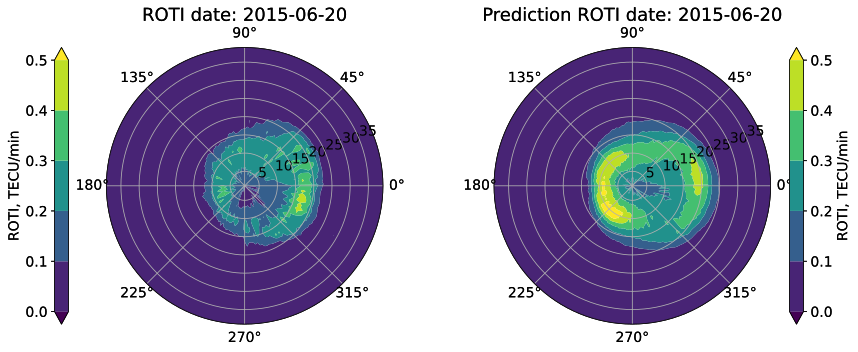

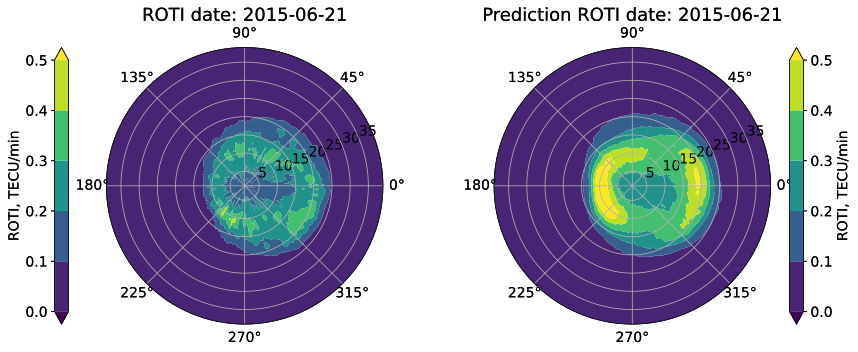

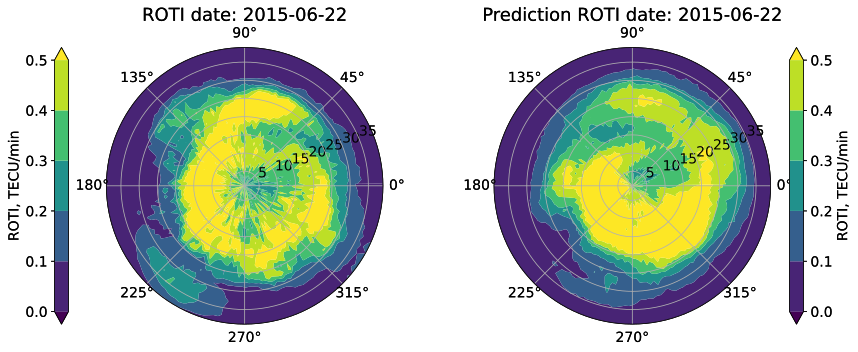

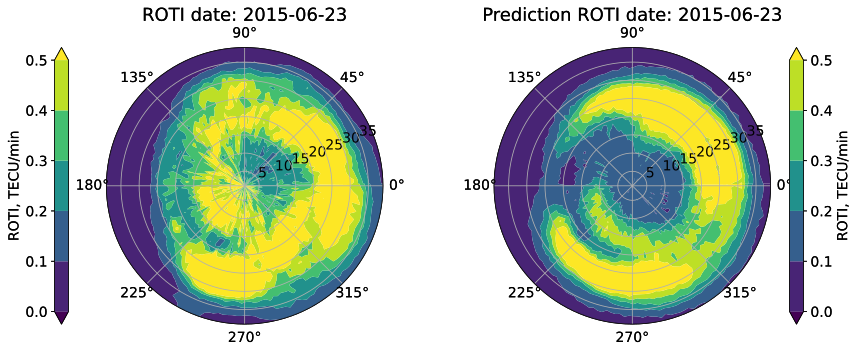

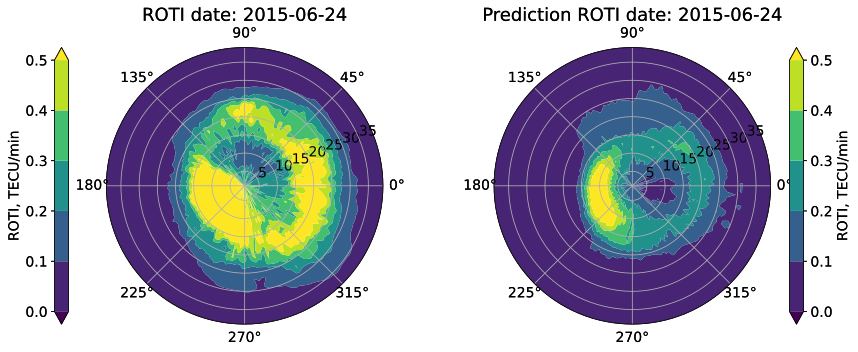

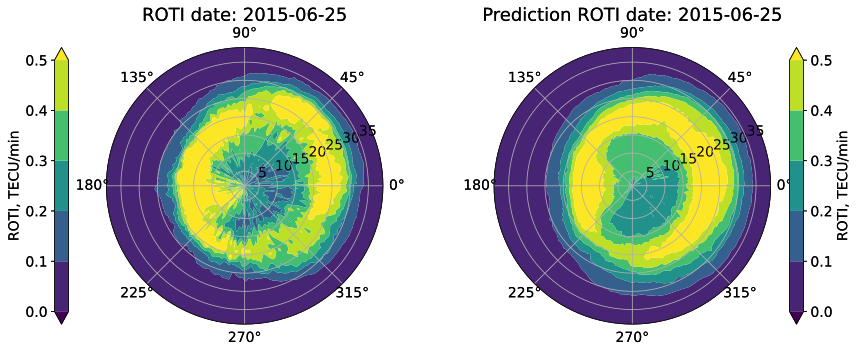

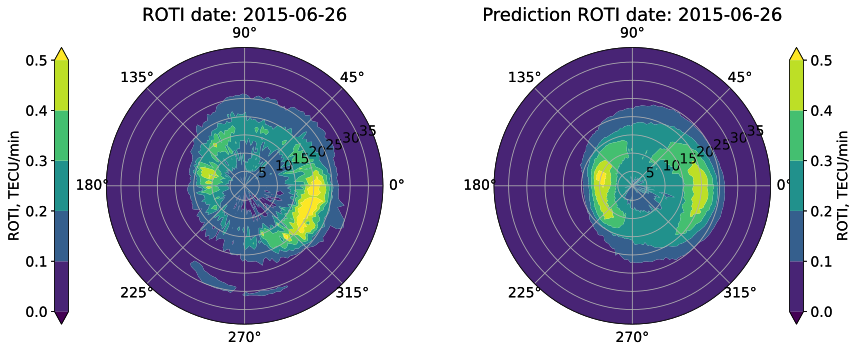

In [48]:
start = 1994
end = 2001

# start = 4455
# end = 4461

y_pred=inception.predict(x_train_test[start:end])

fn.PlotRotiPredictions(start, end, y_pred, x_train_test, roti_map_date, pdf_file="", WriteFile=False)